In [23]:
# import all relevant libraries here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

import wfdb
from wfdb import processing


# assign the correct path to downloaded data and filenames
# realpath is this script path, while data is subfolder in the same dir
# parent_dir =  os.path.dirname(os.path.realpath(__file__))

parent_dir = os.path.abspath('')
data_dir =  os.path.join(parent_dir,'data')


filenames = []

for i in range(10):
    filenames.append('infant'+str(i+1))

# print and list all relevant filenames, as a quick check
print(parent_dir)
print(data_dir)
print(filenames)

def describe_df(df):
    desc = df.describe()
    desc.loc['count'] = desc.loc['count'].astype(int).astype(str)
    desc.loc['nunique'] = df.nunique()
    desc.loc['count_na'] = df.isna().sum()
    desc.iloc[1:] = desc.iloc[1:].applymap('{:.6f}'.format)
    print(desc)


d:\Github\ecg_resp
d:\Github\ecg_resp\data
['infant1', 'infant2', 'infant3', 'infant4', 'infant5', 'infant6', 'infant7', 'infant8', 'infant9', 'infant10']


In [56]:
df = pd.read_csv(data_dir+'\processed\subsampled{postfix}.csv'.format(postfix='_'+filenames[2]))

# filter data both rows & columns
df = df[20000:100000]
df = df[['hrs', 'resp']]

# add time from index
df['time'] = df.index

# add unique id everytime hrs change
df['id'] = (df[['hrs']].diff() != 0).cumsum()

# print descriptions of the df
describe_df(df)


                 hrs         resp          time           id
count          80000        80000         80000        80000
mean      117.616768    22.179220  59999.500000  1386.239175
std         5.482806     1.027225  23094.155105   796.162505
min        21.489971    15.739890  20000.000000     1.000000
25%       114.503815    21.614254  39999.750000   702.000000
50%       117.187500    22.085403  59999.500000  1382.000000
75%       120.481926    22.777121  79999.250000  2068.000000
max       171.428570    27.476752  99999.000000  2773.000000
nunique    81.000000  2952.000000  80000.000000  2773.000000
count_na    0.000000     0.000000      0.000000     0.000000


<AxesSubplot:ylabel='resp'>

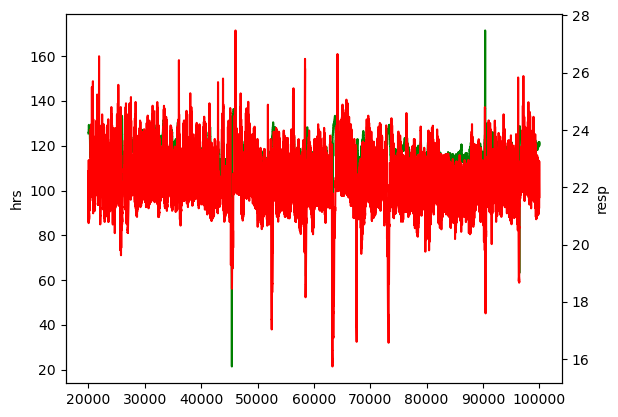

In [57]:
# plot 

sns.lineplot(data=df['hrs'], color="g")
# sns.lineplot(data=df['resp'], color="r")
ax2 = plt.twinx()
# sns.lineplot(data=df['sig'], color="b", ax=ax2)
sns.lineplot(data=df['resp'], color="r", ax=ax2)

In [58]:
# group data into unique continuous hrs, i.e. the generated id
dfg = df.groupby('id')['resp'].apply(list).reset_index(name='resp')

# add back corresponding hrs to each id
dfg = pd.merge(dfg, df[['id', 'hrs']], on='id', how='left')

# inspect in jupyter
dfg

id                                               resp        hrs
0         1  [22.56213714057648, 22.26060133916796, 22.1223...  125.52301
1         1  [22.56213714057648, 22.26060133916796, 22.1223...  125.52301
2         1  [22.56213714057648, 22.26060133916796, 22.1223...  125.52301
3         1  [22.56213714057648, 22.26060133916796, 22.1223...  125.52301
4         1  [22.56213714057648, 22.26060133916796, 22.1223...  125.52301
...     ...                                                ...        ...
79995  2773  [22.219419366290406, 22.17125739800988, 22.081...  121.45749
79996  2773  [22.219419366290406, 22.17125739800988, 22.081...  121.45749
79997  2773  [22.219419366290406, 22.17125739800988, 22.081...  121.45749
79998  2773  [22.219419366290406, 22.17125739800988, 22.081...  121.45749
79999  2773  [22.219419366290406, 22.17125739800988, 22.081...  121.45749

[80000 rows x 3 columns]

In [61]:

# we can expand the generated column of resp list into wide columns
dfr = pd.DataFrame(dfg.resp.values.tolist()).add_prefix('resp_')

dfr = dfr.iloc[:,0:15]

# print descriptions of the df
describe_df(dfr)


              resp_0      resp_1      resp_2      resp_3      resp_4  \
count          80000       80000       80000       80000       80000   
mean       22.216305   22.218798   22.216634   22.214461   22.212111   
std         1.045741    1.044198    1.039319    1.035551    1.032839   
min        15.785260   15.739890   15.785260   15.742682   15.742682   
25%        21.617046   21.617046   21.649154   21.651946   21.653342   
50%        22.133565   22.130773   22.127981   22.125189   22.122397   
75%        22.861579   22.858787   22.859136   22.853203   22.821793   
max        27.224076   27.432778   27.475356   27.435570   27.476752   
nunique   896.000000  908.000000  918.000000  877.000000  891.000000   
count_na    0.000000    0.000000    0.000000    0.000000    0.000000   

              resp_5      resp_6      resp_7      resp_8      resp_9  \
count          80000       80000       80000       80000       79991   
mean       22.204252   22.192657   22.182508   22.176651   22.1

In [62]:
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
  
# Load the data
# dataset = dfr
# # drop = ['hrs', 'sig_min', 'sig_mean', 'sig_max' ]
# y_col = ['hrs']
# X, y =  dataset.drop(columns=y_col), dataset[y_col]

X, y = dfr, dfg['hrs']
  
# Splitting
train_X, test_X, train_y, test_y = train_test_split(X, y,
                      test_size = 0.3, random_state = 123)


  
# Instantiation
xgb_r = xg.XGBRegressor(objective ='reg:linear',
                  n_estimators = 100, seed = 123)
  
# Fitting the model
xgb_r.fit(train_X, train_y)
  
# Predict the model
pred = xgb_r.predict(test_X)
  
# RMSE Computation
rmse = np.sqrt(MSE(test_y, pred))
print("RMSE : % f" %(rmse))

# r2square compution
r2 = r2_score(test_y, pred)
print("R2 : % f" %(r2))

c:\Users\hafiidz\anaconda3\envs\boost\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[12:13:24] WARNING: c:\windows\temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
RMSE :  1.284909
R2 :  0.943207


<AxesSubplot:xlabel='y_actual', ylabel='y_pred'>

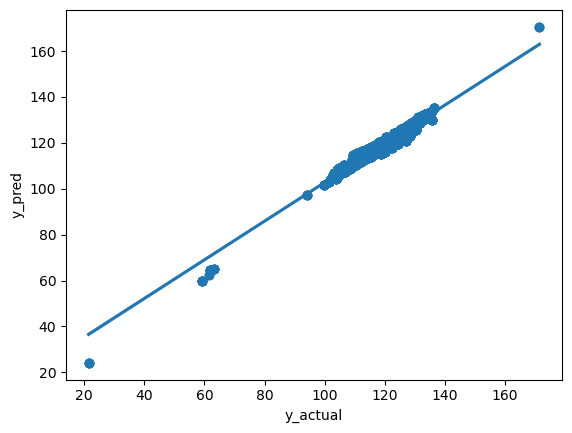

In [63]:
dft = pd.DataFrame({'y_actual':test_y, 'y_pred': pred})

sns.regplot(data=dft, x='y_actual', y='y_pred')


In [66]:
df2 = pd.read_csv(data_dir+'\processed\subsampled{postfix}.csv'.format(postfix='_'+filenames[2]))

# filter data both rows & columns
df2 = df2[100000:200000]
df2 = df2[['hrs', 'resp']]

# add time from index
df2['time'] = df2.index

# add unique id everytime hrs change
df2['id'] = (df2[['hrs']].diff() != 0).cumsum()

# print descriptions of the df
describe_df(df2)


# group data into unique continuous hrs, i.e. the generated id
dfg2 = df2.groupby('id')['resp'].apply(list).reset_index(name='resp')

# add back corresponding hrs to each id
dfg2 = pd.merge(dfg2, df2[['id', 'hrs']], on='id', how='left')

# we can expand the generated column of resp list into wide columns
dfr2 = pd.DataFrame(dfg2.resp.values.tolist()).add_prefix('resp_')

dfr2 = dfr2.iloc[:,0:15]

# print descriptions of the df
describe_df(dfr2)



                 hrs         resp           time           id
count         100000       100000         100000       100000
mean      126.282454    22.251157  149999.500000  1724.380900
std         8.826188     1.105780   28867.657797  1005.144707
min        84.033615    17.117741  100000.000000     1.000000
25%       120.481926    21.615650  124999.750000   855.000000
50%       125.523010    22.085403  149999.500000  1716.000000
75%       130.434780    22.813417  174999.250000  2590.000000
max       214.285720    29.158931  199999.000000  3491.000000
nunique   110.000000  3421.000000  100000.000000  3491.000000
count_na    0.000000     0.000000       0.000000     0.000000
               resp_0       resp_1       resp_2       resp_3       resp_4  \
count          100000       100000       100000       100000        99996   
mean        22.294985    22.294188    22.293086    22.286962    22.281040   
std          1.114136     1.114186     1.113831     1.112514     1.112700   
min       

RMSE :  1.284909
R2 : -0.967653


<AxesSubplot:xlabel='y_actual', ylabel='y_pred'>

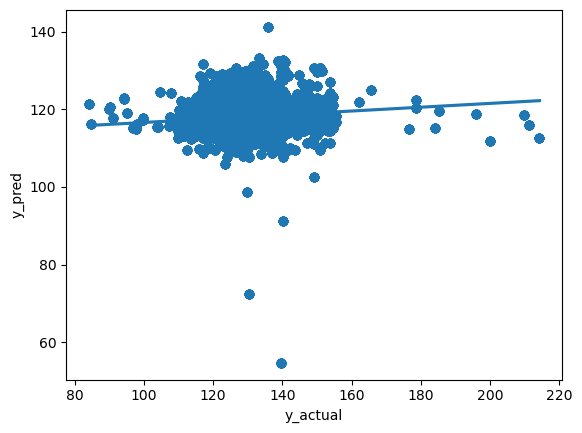

In [67]:
blind_X, blind_y = dfr2, dfg2['hrs']

# Predict the model
blind_pred = xgb_r.predict(blind_X)
  
# RMSE Computation
blind_rmse = np.sqrt(MSE(blind_y, blind_pred))
print("RMSE : % f" %(rmse))

# r2square compution
blind_r2 = r2_score(blind_y, blind_pred)
print("R2 : % f" %(blind_r2))


dft = pd.DataFrame({'y_actual':blind_y, 'y_pred': blind_pred})

sns.regplot(data=dft, x='y_actual', y='y_pred')